In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Assume a dataframe where each row represents a game and the columns contain relevant features
data = pd.read_csv('Games for Model-All Tournament Games 2022-2024.csv')
# All features
#features = ['Seed','SRS','SOS','Tm.','Opp.','Pace','ORtg','FTr','3PAr','TS%','TRB%','AST%','STL%','BLK%','eFG%','TOV%','ORB%','FT/FGA']  # Replace with actual stat columns

# Removal of Tm. and Opp. columns
features = ['Seed','SRS','SOS','Pace','ORtg','FTr','3PAr','TS%','TRB%','AST%','STL%','BLK%','eFG%','TOV%','ORB%','FT/FGA']
X = data[features]
y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Feature scaling (standardization) for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")


Mean Absolute Error: 5.123199999999999
R^2 Score: 0.7586994979197518


In [3]:
# Define function for running the model on future games
def model_run(future_data, model, scaler, features):
    future_data_scaled = scaler.transform(future_data[features])  # Same feature scaling as training data
    future_predictions = model.predict(future_data_scaled)
    return future_predictions

def df_setup(data_to_update, predictions):
    if len(data_to_update) == len(predictions):
        data_to_update['Predicted_Score_Diff'] = predictions
        data_to_update['WinLoss'] = data_to_update.apply(
            lambda row: 'Win' if (
                (row['Predicted_Score_Diff'] > row['Spread'] and row['Actual Score'] > row['Spread']) or
                (row['Predicted_Score_Diff'] < row['Spread'] and row['Actual Score'] < row['Spread'])
            ) else 'Loss',
            axis=1
        )
        return data_to_update
    else:
        return "Predictions don't match CSV"
        

In [4]:

future_data = pd.read_csv('PredictedGames-Table 1.csv')
predictions = model_run(future_data, model, scaler, features)

# Output future predictions (score difference)
print("Predicted score differences for 2025 Round 1:")
print(predictions)

Predicted score differences for 2025 Round 1:
[25.323 26.102 29.648 24.782 20.212 24.24  26.699 23.431  9.28  21.66
 26.629 13.897  8.283 18.161 12.872 10.89   7.271  9.155  0.129  9.692
  1.461  3.196  5.259  3.706  5.55   1.214  5.705  5.716  0.316 -4.76
  1.336 -0.4  ]


In [5]:
data_to_update = pd.read_csv('24_25 Diff-2021-22 NCAA Data.csv')
data_to_update = df_setup(data_to_update, predictions)

if not isinstance(data_to_update, pd.DataFrame):
        print("❌ Error: You probably loaded the wrong CSV file — this is not a DataFrame.")
else:
        print("✅ DataFrame loaded correctly. Continuing...")
        

columns_to_display = ['HighSeed', 'HSeed','LowSeed','LSeed', 'Spread', 'Predicted_Score_Diff','Actual Score' ,'WinLoss']  # Adjust this list based on your needs
selected_data = data_to_update[columns_to_display]

#Display the data in a presentation-friendly format
#print(selected_data.to_string(index=False))


✅ DataFrame loaded correctly. Continuing...


In [6]:
# Full markdown table
markdown_table = selected_data.to_markdown(index=False)

# Save to a .md file to copy into your README
with open("tableR1.md", "w") as f:
    f.write(markdown_table)


In [7]:
win_loss_counts = selected_data['WinLoss'].value_counts()
print(win_loss_counts)

WinLoss
Win     19
Loss    13
Name: count, dtype: int64


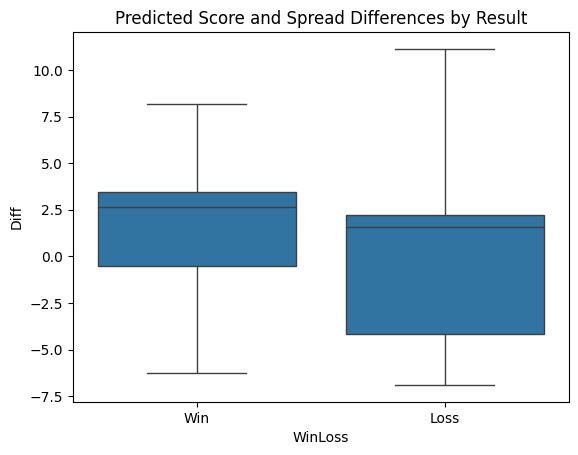

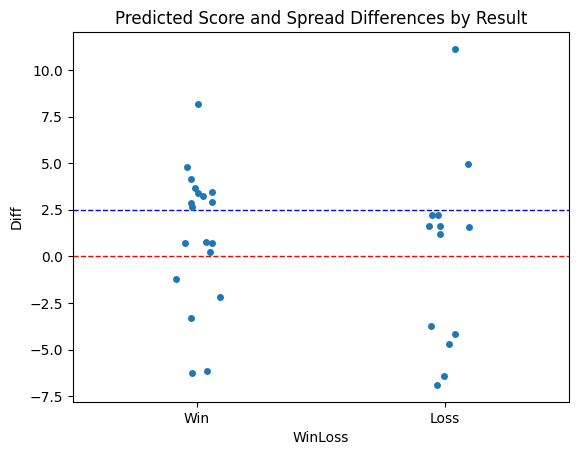

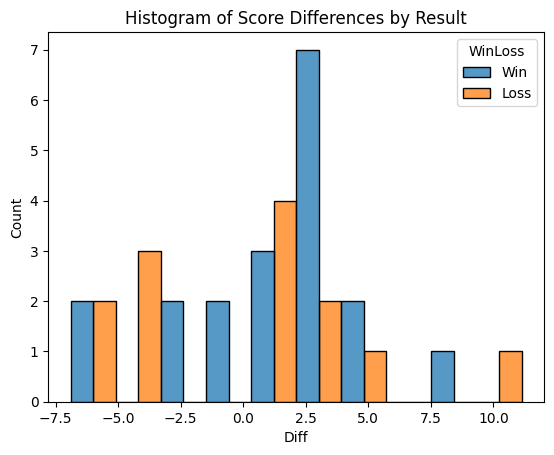

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the difference between Predicted_Score_Diff and Spread
diff_array = data_to_update['Predicted_Score_Diff'] - data_to_update['Spread']

# Add the difference as a new column to the DataFrame (optional)
data_to_update['Diff'] = diff_array

sns.boxplot(x="WinLoss", y="Diff", data=data_to_update)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

sns.stripplot(x="WinLoss", y="Diff", data=data_to_update, jitter=True)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=2.5, color = 'blue', linestyle='--', linewidth=1)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

sns.histplot(data=data_to_update, x="Diff", hue="WinLoss", multiple="dodge", bins=10)
plt.title("Histogram of Score Differences by Result")
plt.show()

In [9]:
# Filter rows where Diff column value is positive
positive_diff_data = data_to_update[data_to_update['Diff'] > 0]

# Count the occurrences of Win and Loss in the filtered data
positive_diff_win_loss_counts = positive_diff_data['WinLoss'].value_counts()

print(positive_diff_win_loss_counts)

WinLoss
Win     14
Loss     8
Name: count, dtype: int64


In [10]:
# Filter rows where Diff column value is positive
positive_diff_data = data_to_update[data_to_update['Diff'] > 2.5]

# Count the occurrences of Win and Loss in the filtered data
positive_diff_win_loss_counts = positive_diff_data['WinLoss'].value_counts()

print(positive_diff_win_loss_counts)

WinLoss
Win     10
Loss     2
Name: count, dtype: int64


In [11]:
# Get feature importances from the model
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

   Feature  Importance
1      SRS    0.297369
2      SOS    0.225367
10    STL%    0.064724
11    BLK%    0.053258
13    TOV%    0.050606
8     TRB%    0.050468
3     Pace    0.046428
6     3PAr    0.030373
14    ORB%    0.027915
15  FT/FGA    0.027240
0     Seed    0.027016
9     AST%    0.026547
4     ORtg    0.024682
5      FTr    0.020988
12    eFG%    0.014735
7      TS%    0.012286


In [12]:
# Use same model to predicted Round 2 games
future_data = pd.read_csv('PredictedGamesR2-Table 1.csv')
predictions = model_run(future_data, model, scaler, features)

# Output future predictions (score difference)
print("Predicted score differences for future games:")
print(predictions)

Predicted score differences for future games:
[ 1.402 -2.571  0.675  1.78   9.906  7.045 -1.143  4.59  -2.607  3.422
 11.906  5.183  2.286  3.466 -0.881  8.961]


In [13]:
#Add predicted values and determine Win or Loss for each game

data_to_update = pd.read_csv('24_25 Diff Round 2-2021-22 NCAA Data.csv')
data_to_update = df_setup(data_to_update, predictions)

if not isinstance(data_to_update, pd.DataFrame):
        print("❌ Error: You probably loaded the wrong CSV file — this is not a DataFrame.")
else:
        print("✅ DataFrame loaded correctly. Continuing...")
        

columns_to_display = ['HighSeed', 'HSeed','LowSeed','LSeed', 'Spread', 'Predicted_Score_Diff','Actual Score' ,'WinLoss']  # Adjust this list based on your needs
selected_dataR2 = data_to_update[columns_to_display]

#Display the data in a presentation-friendly format
print(selected_dataR2.to_string(index=False))


✅ DataFrame loaded correctly. Continuing...
       HighSeed  HSeed           LowSeed  LSeed  Spread  Predicted_Score_Diff  Actual Score WinLoss
         Auburn      1         Creighton      9     9.0                 1.402            12    Loss
           Duke      1            Baylor      9    12.0                -2.571            23    Loss
        Florida      1       Connecticut      8     9.0                 0.675             2     Win
        Houston      1           Gonzaga      8     5.0                 1.780             5    Loss
 Michigan State      2        New Mexico     10     7.5                 9.906             8     Win
        Alabama      2 Saint Mary’s (CA)      7     6.0                 7.045            14     Win
St. John's (NY)      2          Arkansas     10     7.5                -1.143            -9     Win
      Tennessee      2              UCLA      7     5.0                 4.590             9    Loss
     Iowa State      3       Mississippi      6     5.0 

In [14]:
# Full markdown table
markdown_table = selected_dataR2.to_markdown(index=False)

# Save to a .md file to copy into your README
with open("tableR2.md", "w") as f:
    f.write(markdown_table)


In [15]:
win_loss_counts = selected_dataR2['WinLoss'].value_counts()
print(win_loss_counts)

WinLoss
Win     10
Loss     6
Name: count, dtype: int64


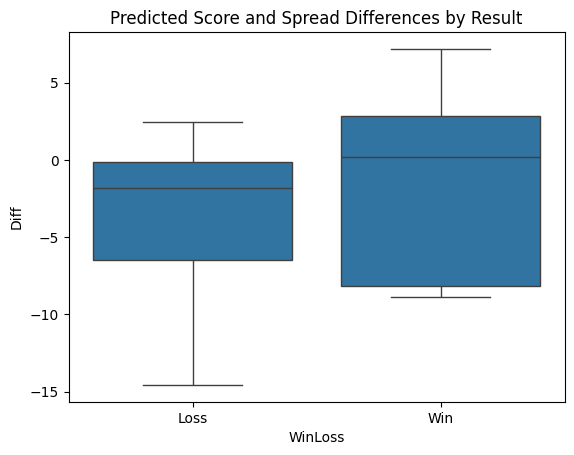

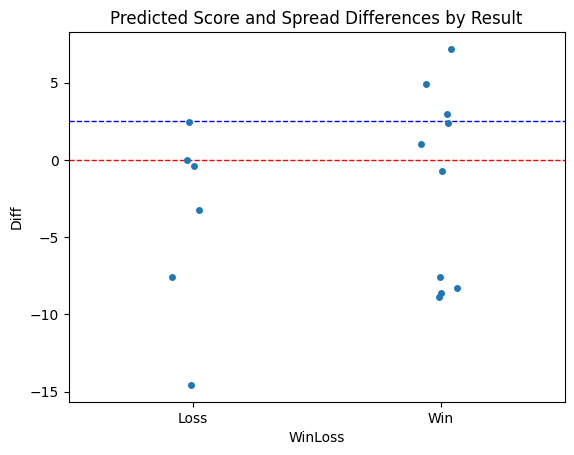

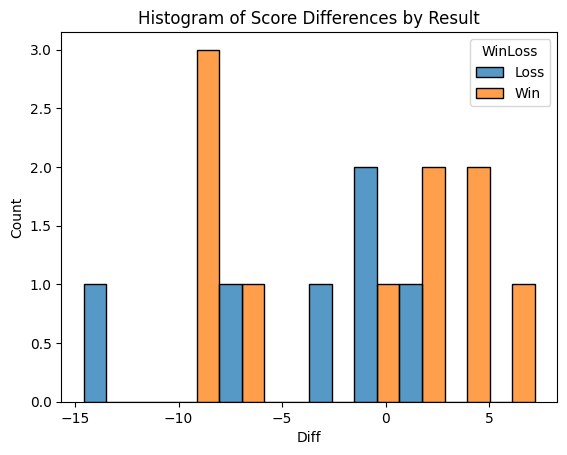

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the difference between Predicted_Score_Diff and Spread
diff_array = data_to_update['Predicted_Score_Diff'] - data_to_update['Spread']

# Add the difference as a new column to the DataFrame (optional)
data_to_update['Diff'] = diff_array

sns.boxplot(x="WinLoss", y="Diff", data=data_to_update)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

sns.stripplot(x="WinLoss", y="Diff", data=data_to_update, jitter=True)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=2.5, color = 'blue', linestyle='--', linewidth=1)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

sns.histplot(data=data_to_update, x="Diff", hue="WinLoss", multiple="dodge", bins=10)
plt.title("Histogram of Score Differences by Result")
plt.show()



In [16]:
# Filter rows where Diff column value is positive
positive_diff_data = data_to_update[data_to_update['Diff'] > 0]

# Count the occurrences of Win and Loss in the filtered data
positive_diff_win_loss_counts = positive_diff_data['WinLoss'].value_counts()

print(positive_diff_win_loss_counts)

WinLoss
Win     5
Loss    1
Name: count, dtype: int64


In [17]:
# Filter rows where Diff column value is positive
positive_diff_data = data_to_update[data_to_update['Diff'] > 2.5]

# Count the occurrences of Win and Loss in the filtered data
positive_diff_win_loss_counts = positive_diff_data['WinLoss'].value_counts()

print(positive_diff_win_loss_counts)

WinLoss
Win    3
Name: count, dtype: int64


In [18]:

future_data = pd.read_csv('PredictedGamesR3-Table 1.csv')
predictions = model_run(future_data, model, scaler, features)

# Output future predictions (score difference)
print("Predicted score differences for future games:")
print(predictions)

Predicted score differences for future games:
[ 1.826 -2.19   5.197 -0.458  9.387  4.68   0.34   6.561]


In [19]:
data_to_update = pd.read_csv('24_25 Diff Round 3-2021-22 NCAA Data.csv')
data_to_update = df_setup(data_to_update, predictions)

if not isinstance(data_to_update, pd.DataFrame):
        print("❌ Error: You probably loaded the wrong CSV file — this is not a DataFrame.")
else:
        print("✅ DataFrame loaded correctly. Continuing...")
        

columns_to_display = ['HighSeed', 'HSeed','LowSeed','LSeed', 'Spread', 'Predicted_Score_Diff','Actual Score' ,'WinLoss']  # Adjust this list based on your needs
selected_data = data_to_update[columns_to_display]

#Display the data in a presentation-friendly format
print(selected_data.to_string(index=False))


✅ DataFrame loaded correctly. Continuing...
      HighSeed  HSeed       LowSeed  LSeed  Spread  Predicted_Score_Diff  Actual Score WinLoss
        Auburn      1      Michigan      5     9.5                 1.826            13    Loss
          Duke      1       Arizona      4     9.5                -2.190             7     Win
       Florida      1      Maryland      4     6.5                 5.197            16    Loss
       Houston      1        Purdue      4     8.5                -0.458             2     Win
Michigan State      2   Mississippi      6     3.5                 9.387             3    Loss
       Alabama      2 Brigham Young      6     4.5                 4.680            25     Win
     Tennessee      2      Kentucky      3     5.5                 0.340            13    Loss
    Texas Tech      3      Arkansas     10     5.5                 6.561             2    Loss


In [20]:
win_loss_counts = selected_data['WinLoss'].value_counts()
print(win_loss_counts)

WinLoss
Loss    5
Win     3
Name: count, dtype: int64


In [21]:

future_data = pd.read_csv('PredictedGamesR4-Table 1.csv')
predictions = model_run(future_data, model, scaler, features)

# Output future predictions (score difference)
print("Predicted score differences for future games:")
print(predictions)

Predicted score differences for future games:
[ 4.893 -0.799  2.122  2.537]


In [22]:
data_to_update = pd.read_csv('24_25 Diff Round 4-2021-22 NCAA Data.csv')
data_to_update = df_setup(data_to_update, predictions)

if not isinstance(data_to_update, pd.DataFrame):
        print("❌ Error: You probably loaded the wrong CSV file — this is not a DataFrame.")
else:
        print("✅ DataFrame loaded correctly. Continuing...")
        

columns_to_display = ['HighSeed', 'HSeed','LowSeed','LSeed', 'Spread', 'Predicted_Score_Diff','Actual Score' ,'WinLoss']  # Adjust this list based on your needs
selected_data = data_to_update[columns_to_display]

#Display the data in a presentation-friendly format
print(selected_data.to_string(index=False))


✅ DataFrame loaded correctly. Continuing...
HighSeed  HSeed        LowSeed  LSeed  Spread  Predicted_Score_Diff  Actual Score WinLoss
  Auburn      1 Michigan State      2     5.5                 4.893             6    Loss
    Duke      1        Alabama      2     6.5                -0.799            20    Loss
 Florida      1     Texas Tech      3     6.5                 2.122             5     Win
 Houston      1      Tennessee      2     2.5                 2.537            19     Win


In [23]:
#Added results of 2025 Tournament First Round and Updating Model

data = pd.read_csv('Games for Model22-25-All Tournament Games 2022-2025.csv')

features = ['Seed','SRS','SOS','Pace','ORtg','FTr','3PAr','TS%','TRB%','AST%','STL%','BLK%','eFG%','TOV%','ORB%','FT/FGA']
X = data[features]
y = data['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 8.576923076923078
R^2 Score: 0.6111284036355162


In [24]:

future_data = pd.read_csv('PredictedGamesR2-Table 1.csv')
predictions = model_run(future_data, model, scaler, features)

# Output future predictions (score difference)
print("Predicted score differences for future games:")
print(predictions)

Predicted score differences for future games:
[ 1.2   3.59 -1.29  1.47  9.75  4.46  5.34  7.13 -0.5   7.52  7.15  3.03
 -2.94  5.33 -1.62 14.39]


In [25]:
data_to_update = pd.read_csv('24_25 Diff Round 2-2021-22 NCAA Data.csv')
data_to_update = df_setup(data_to_update, predictions)

if not isinstance(data_to_update, pd.DataFrame):
        print("❌ Error: You probably loaded the wrong CSV file — this is not a DataFrame.")
else:
        print("✅ DataFrame loaded correctly. Continuing...")
        

columns_to_display = ['HighSeed', 'HSeed','LowSeed','LSeed', 'Spread', 'Predicted_Score_Diff','Actual Score' ,'WinLoss']  # Adjust this list based on your needs
selected_dataR2_25 = data_to_update[columns_to_display]

#Display the data in a presentation-friendly format
print(selected_dataR2_25.to_string(index=False))


✅ DataFrame loaded correctly. Continuing...
       HighSeed  HSeed           LowSeed  LSeed  Spread  Predicted_Score_Diff  Actual Score WinLoss
         Auburn      1         Creighton      9     9.0                  1.20            12    Loss
           Duke      1            Baylor      9    12.0                  3.59            23    Loss
        Florida      1       Connecticut      8     9.0                 -1.29             2     Win
        Houston      1           Gonzaga      8     5.0                  1.47             5    Loss
 Michigan State      2        New Mexico     10     7.5                  9.75             8     Win
        Alabama      2 Saint Mary’s (CA)      7     6.0                  4.46            14    Loss
St. John's (NY)      2          Arkansas     10     7.5                  5.34            -9     Win
      Tennessee      2              UCLA      7     5.0                  7.13             9     Win
     Iowa State      3       Mississippi      6     5.0 

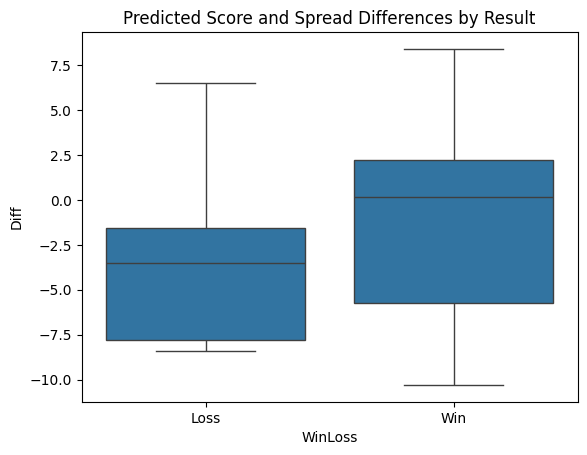

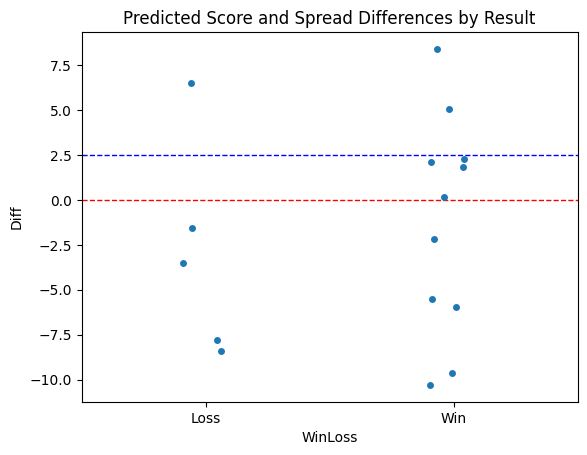

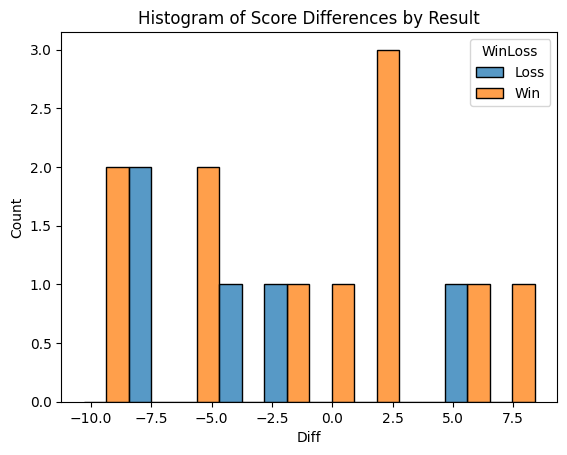

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the difference between Predicted_Score_Diff and Spread
diff_array = data_to_update['Predicted_Score_Diff'] - data_to_update['Spread']

# Add the difference as a new column to the DataFrame (optional)
data_to_update['Diff'] = diff_array

sns.boxplot(x="WinLoss", y="Diff", data=data_to_update)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

sns.stripplot(x="WinLoss", y="Diff", data=data_to_update, jitter=True)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=2.5, color = 'blue', linestyle='--', linewidth=1)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

sns.histplot(data=data_to_update, x="Diff", hue="WinLoss", multiple="dodge", bins=10)
plt.title("Histogram of Score Differences by Result")
plt.show()



In [27]:
# Filter rows where Diff column value is positive
positive_diff_data = data_to_update[data_to_update['Diff'] > 0]

# Count the occurrences of Win and Loss in the filtered data
positive_diff_win_loss_counts = positive_diff_data['WinLoss'].value_counts()

print(positive_diff_win_loss_counts)

WinLoss
Win     6
Loss    1
Name: count, dtype: int64


In [30]:
selected_dataR2['Predicted Diff 22-25 Model'] = selected_dataR2_25['Predicted_Score_Diff']
selected_dataR2['WinLoss 22-25'] = selected_dataR2_25['WinLoss']

#columns_to_display = ['HighSeed', 'HSeed','LowSeed','LSeed', 'Spread', 'Actual Score','Predicted_Score_Diff','WinLoss','Predicted Diff 22-25 Model', 'WinLoss 22-25']
print(selected_dataR2.to_string(index=False))


       HighSeed  HSeed           LowSeed  LSeed  Spread  Predicted_Score_Diff  Actual Score WinLoss  Predicted Diff 22-25 Model WinLoss 22-25
         Auburn      1         Creighton      9     9.0                 1.402            12    Loss                        1.20          Loss
           Duke      1            Baylor      9    12.0                -2.571            23    Loss                        3.59          Loss
        Florida      1       Connecticut      8     9.0                 0.675             2     Win                       -1.29           Win
        Houston      1           Gonzaga      8     5.0                 1.780             5    Loss                        1.47          Loss
 Michigan State      2        New Mexico     10     7.5                 9.906             8     Win                        9.75           Win
        Alabama      2 Saint Mary’s (CA)      7     6.0                 7.045            14     Win                        4.46          Loss
St. Jo

In [33]:
win_loss_counts = selected_dataR2['WinLoss 22-25'].value_counts()
print(win_loss_counts)

WinLoss 22-25
Win     11
Loss     5
Name: count, dtype: int64


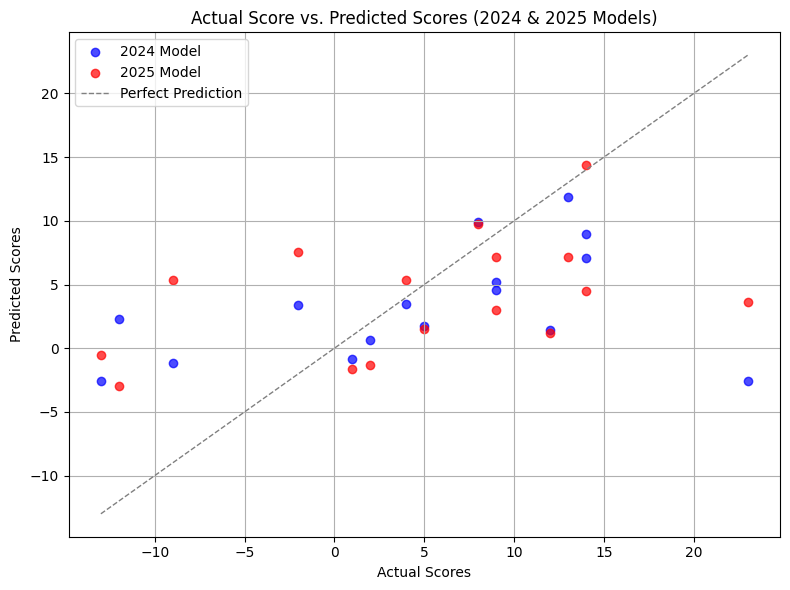

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))

# Plot old predicted scores
plt.scatter(selected_dataR2['Actual Score'], selected_dataR2['Predicted_Score_Diff'], color='blue', label='2024 Model', alpha=0.7)

# Plot new predicted scores
plt.scatter(selected_dataR2['Actual Score'], selected_dataR2['Predicted Diff 22-25 Model'], color='red', label='2025 Model', alpha=0.7)

# Plot formatting
plt.plot([selected_dataR2['Actual Score'].min(), selected_dataR2['Actual Score'].max()],
         [selected_dataR2['Actual Score'].min(), selected_dataR2['Actual Score'].max()],
         color='gray', linestyle='--', linewidth=1, label='Perfect Prediction')

plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual Score vs. Predicted Scores (2024 & 2025 Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


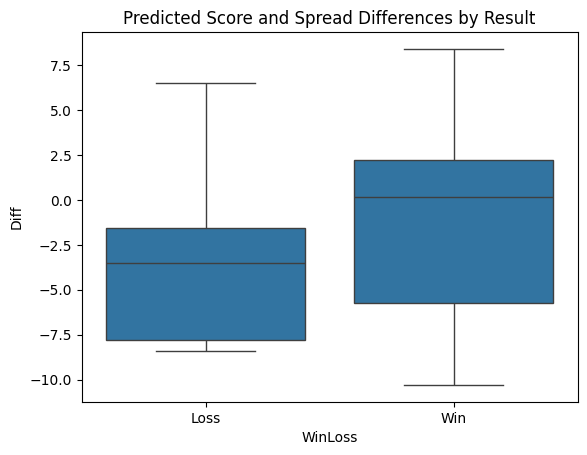

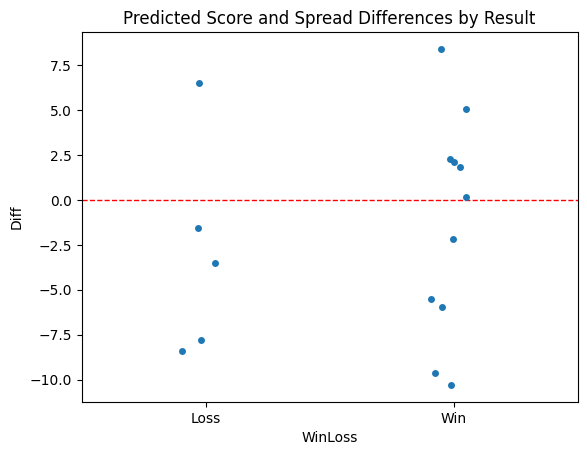

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the difference between Predicted_Score_Diff and Spread
diff_array = data_to_update['Predicted_Score_Diff'] - data_to_update['Spread']

# Add the difference as a new column to the DataFrame (optional)
data_to_update['Diff'] = diff_array

sns.boxplot(x="WinLoss", y="Diff", data=data_to_update)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

sns.stripplot(x="WinLoss", y="Diff", data=data_to_update, jitter=True)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
#plt.axhline(y=2.5, color = 'blue', linestyle='--', linewidth=1)
plt.title("Predicted Score and Spread Differences by Result")
plt.show()

#sns.histplot(data=data_to_update, x="Diff", hue="WinLoss", multiple="dodge", bins=10)
#plt.title("Histogram of Score Differences by Result")
#plt.show()



In [37]:


future_data = pd.read_csv('PredictedGamesR3-Table 1.csv')
predictions = model_run(future_data, model, scaler, features)

# Output future predictions (score difference)
print("Predicted score differences for future games:")
print(predictions)

Predicted score differences for future games:
[ 2.8   1.36  6.61 -1.7   6.88  2.51  0.78 11.93]


In [38]:
data_to_update = pd.read_csv('24_25 Diff Round 3-2021-22 NCAA Data.csv')
data_to_update = df_setup(data_to_update, predictions)

if not isinstance(data_to_update, pd.DataFrame):
        print("❌ Error: You probably loaded the wrong CSV file — this is not a DataFrame.")
else:
        print("✅ DataFrame loaded correctly. Continuing...")
        

columns_to_display = ['HighSeed', 'HSeed','LowSeed','LSeed', 'Spread', 'Predicted_Score_Diff','Actual Score' ,'WinLoss']  # Adjust this list based on your needs
selected_data = data_to_update[columns_to_display]

#Display the data in a presentation-friendly format
print(selected_data.to_string(index=False))


✅ DataFrame loaded correctly. Continuing...
      HighSeed  HSeed       LowSeed  LSeed  Spread  Predicted_Score_Diff  Actual Score WinLoss
        Auburn      1      Michigan      5     9.5                  2.80            13    Loss
          Duke      1       Arizona      4     9.5                  1.36             7     Win
       Florida      1      Maryland      4     6.5                  6.61            16     Win
       Houston      1        Purdue      4     8.5                 -1.70             2     Win
Michigan State      2   Mississippi      6     3.5                  6.88             3    Loss
       Alabama      2 Brigham Young      6     4.5                  2.51            25    Loss
     Tennessee      2      Kentucky      3     5.5                  0.78            13    Loss
    Texas Tech      3      Arkansas     10     5.5                 11.93             2    Loss
